In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip --no-cache-dir install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 12.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

from nlpaug.util import Action
import nlpaug.augmenter.word as word_augmenter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten, Bidirectional, LSTM, GRU

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [5]:
df_train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/kaggle_comp/disaster_tweets/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/kaggle_comp/disaster_tweets/test.csv')
df_sample = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/kaggle_comp/disaster_tweets/sample_submission.csv')

In [6]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_train.shape

(7613, 5)

In [8]:
#df_train['keyword'].unique()

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
df_train.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of          id  keyword  location   text  target
0     False     True      True  False   False
1     False     True      True  False   False
2     False     True      True  False   False
3     False     True      True  False   False
4     False     True      True  False   False
...     ...      ...       ...    ...     ...
7608  False     True      True  False   False
7609  False     True      True  False   False
7610  False     True      True  False   False
7611  False     True      True  False   False
7612  False     True      True  False   False

[7613 rows x 5 columns]>

In [11]:
df_train['target'].unique()

array([1, 0])

In [12]:
pd.DataFrame(df_train.isnull().sum(), columns=['Missing Counts'])

,Missing Counts
id,0
keyword,61
location,2533
text,0
target,0


In [13]:
disaster_percentage = (df_train['target'].value_counts()[1] * 100) / df_train.shape[0]
blessing_percentage = (df_train['target'].value_counts()[0] * 100) / df_train.shape[0]

print(f'Percentage of blessing data is: { round(blessing_percentage, 2) }')
print(f'Percentage of disaster data is: {round(disaster_percentage, 2)}')

Percentage of blessing data is: 57.03
Percentage of disaster data is: 42.97


Data Cleaning

In [14]:
STOPWORDS = stopwords.words('english')
PUNCTUATION = string.punctuation

In [15]:
def remove_urls(text):    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [16]:
df_train['text'] = df_train['text'].apply(remove_urls)

In [17]:
df_train['text'] = df_train['text'].str.lower()

In [18]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


In [19]:
def remove_punctuation(series):
  no_punctuation = "".join([word for word in series if word not in PUNCTUATION])
  return no_punctuation

In [20]:
df_train['text'] = df_train['text'].apply(remove_punctuation)

In [21]:
def remove_extra_white_spaces(series):
  single_char_pattern = r'\s+[a-zA-Z]\s+'
  without_sc = re.sub(pattern=single_char_pattern, repl=" ", string = series)
  return without_sc

In [22]:
df_train['text'] = df_train['text'].apply(remove_extra_white_spaces)

In [23]:
def remove_stopwords(text):
    no_stopwords = []    
    tokens = word_tokenize(text)
    
    for i in range(len(tokens)):
        if tokens[i] not in STOPWORDS:
            no_stopwords.append(tokens[i])
            
    return " ".join(no_stopwords)

In [24]:
df_train['text'] = df_train['text'].apply(remove_stopwords)

In [25]:
def lemmatize_text(text):    
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

In [26]:
df_train['text'] = df_train['text'].apply(lemmatize_text)

In [27]:
df_train['text_Length'] = df_train['text'].apply(len)

In [28]:
df_train.head()

,id,keyword,location,text,target,text_Length
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,42
1,4,NaN,NaN,forest fire near la ronge sask canada,1,37
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,85
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,57
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,54


Most Frequent Words in Disaster Data

In [29]:
disaster_df = df_train[df_train['target'] == 1]

disaster_df = disaster_df.reset_index().drop('index', axis=1)

In [30]:
disaster_counter = Counter()

for sent in disaster_df['text'].values:
  for word in sent.split():
    if word.lower() not in STOPWORDS:
      disaster_counter[word] += 1

In [31]:
top_disaster_words = pd.DataFrame(disaster_counter.most_common(20), columns=['Disaster', 'Counts'])
top_disaster_words.style.background_gradient()

,Disaster,Counts
0,fire,262
1,news,136
2,via,121
3,disaster,117
4,california,115
5,suicide,110
6,police,107
7,people,106
8,amp,106
9,family,105


In [32]:
COLOR = "#4a8fdd"

In [33]:
fig = px.histogram(top_disaster_words,
                   x = 'Disaster',
                   color_discrete_sequence=[COLOR],
                   y = 'Counts', title="<b>Top 20 Disaster Words in dataset</b>")

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))


fig.show()

In [34]:
def plot_word_cloud(dataframe, series):
    try:
        text = ' '.join(dataframe[series])

        wordcloud = WordCloud(width = 1600 , height = 800, 
                              background_color ='black',                          
                              max_words=2000,
                              max_font_size=300,
                              min_font_size = 20).generate(text)

        plt.figure(figsize=(12, 8), facecolor = 'k', edgecolor = 'k' )
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis("off")
        plt.tight_layout(pad = 0) 
        plt.show()
    
    except TypeError:
        print("Expected str instance")

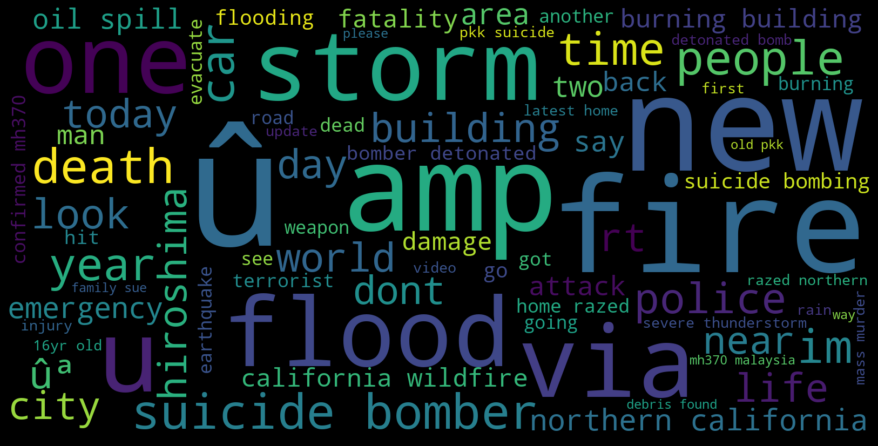

In [35]:
plot_word_cloud(disaster_df, "text")

Most Frequent Words in Ham Data

In [36]:
blessing_df = df_train[df_train['target'] == 0]

blessing_df = blessing_df.reset_index().drop('index', axis=1)

In [37]:
blessing_counter = Counter()
for sent in blessing_df['text'].values:
  for word in sent.split():
    if word.lower() not in STOPWORDS:
      blessing_counter[word] += 1

In [38]:
top_blessing_words = pd.DataFrame(blessing_counter.most_common(20), columns=['Blessing', 'Counts'])
top_blessing_words.style.background_gradient()

,Blessing,Counts
0,like,255
1,im,243
2,amp,192
3,get,185
4,new,168
5,dont,141
6,one,136
7,body,116
8,time,103
9,video,102


In [39]:
fig = px.histogram(top_blessing_words,
                   x = 'Blessing',
                   color_discrete_sequence=[COLOR],
                   y = 'Counts', title="<b>Top 20 Blessing Words in dataset</b>")

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))


fig.show()

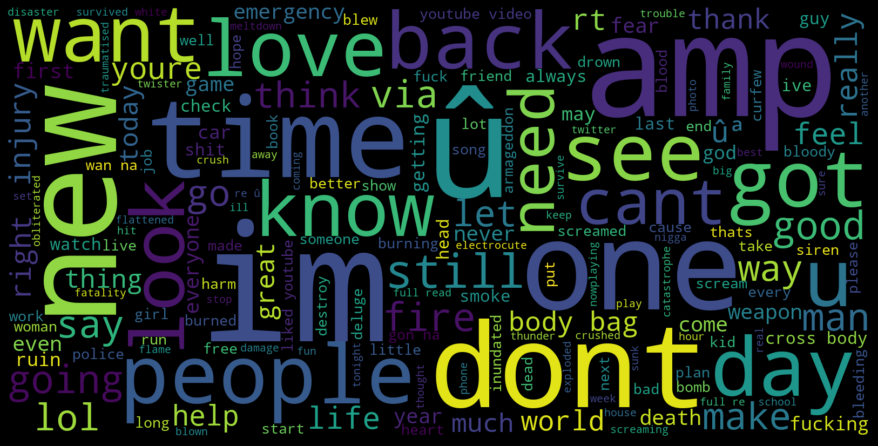

In [40]:
plot_word_cloud(blessing_df, "text")

In [41]:
Message = df_train['text'].values
Category = df_train['target'].values

In [42]:
VOCAB_SIZE = 1000
MAX_LEN = df_train['text_Length'].max()
EMBEDDING_VECTOR_SIZE = 6

In [43]:
encoded_message = [one_hot(msg, VOCAB_SIZE) for msg in Message]

In [44]:
padded_message = pad_sequences(encoded_message, maxlen=MAX_LEN, padding='post')

In [45]:
X = padded_message
y = Category

In [46]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_VECTOR_SIZE, input_length = MAX_LEN, name='Embedding'))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 137, 6)            6000      
                                                                 
 bidirectional (Bidirectiona  (None, 137, 256)         138240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              123648    
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4

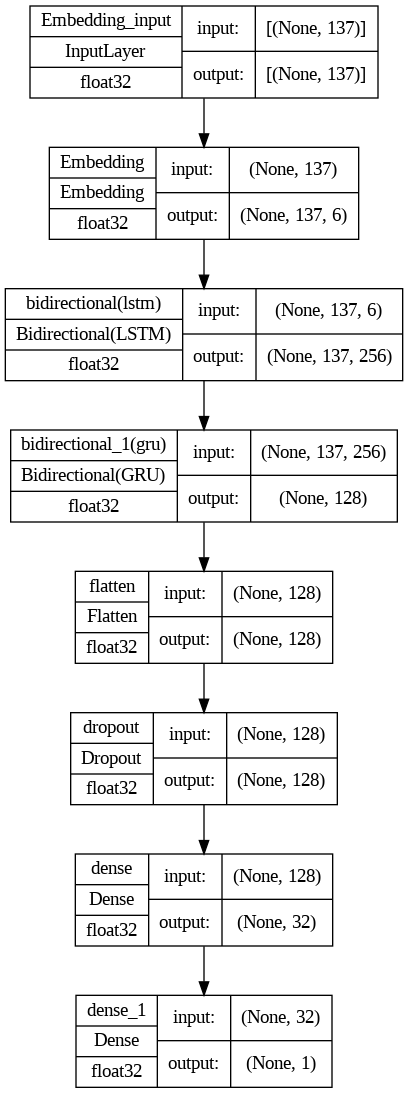

In [48]:
plot_model(model, show_dtype=True, show_layer_names=True, show_shapes=True)

In [49]:
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
history = model.fit(X, y,  epochs=50, batch_size=100)

Epoch 1/50
77/77 [==============================] - 98s 1s/step - loss: 0.6484 - accuracy: 0.6191
Epoch 2/50
77/77 [==============================] - 82s 1s/step - loss: 0.5078 - accuracy: 0.7567
Epoch 3/50
77/77 [==============================] - 77s 994ms/step - loss: 0.4759 - accuracy: 0.7822
Epoch 4/50
77/77 [==============================] - 78s 1s/step - loss: 0.4527 - accuracy: 0.7980
Epoch 5/50
77/77 [==============================] - 79s 1s/step - loss: 0.4243 - accuracy: 0.8131
Epoch 6/50
77/77 [==============================] - 79s 1s/step - loss: 0.4163 - accuracy: 0.8193
Epoch 7/50
77/77 [==============================] - 80s 1s/step - loss: 0.4045 - accuracy: 0.8270
Epoch 8/50
77/77 [==============================] - 78s 1s/step - loss: 0.3920 - accuracy: 0.8320
Epoch 9/50
77/77 [==============================] - 77s 997ms/step - loss: 0.3863 - accuracy: 0.8412
Epoch 10/50
77/77 [==============================] - 79s 1s/step - loss: 0.3762 - accuracy: 0.8426
Epoch 11/50
7

In [51]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
#val_loss = history.history['val_loss']
#val_acc = history.history['val_accuracy']
epoch = [i + 1 for i in range(len(train_acc))]

In [52]:
acc_loss_df = pd.DataFrame({"Training Loss" : train_loss,
                            "Train Accuracy" : train_acc,
                            "Epoch":epoch})


acc_loss_df.style.bar(color = COLOR)

,Training Loss,Train Accuracy,Epoch
0,0.648410,0.619073,1
1,0.507778,0.756732,2
2,0.475906,0.782215,3
3,0.452666,0.797977,4
4,0.424313,0.813083,5
5,0.416338,0.819257,6
6,0.404526,0.827006,7
7,0.392014,0.831998,8
8,0.386346,0.841193,9
9,0.376155,0.842638,10


In [53]:
loss, acc = model.evaluate(X, y)

238/238 [==============================] - 36s 141ms/step - loss: 0.2410 - accuracy: 0.9150


In [54]:
acc = np.round(acc, 2) * 100 
loss = np.round(loss, 2) * 100

print(f"Accuracy on unseen data is: { acc } %")
print(f'Loss on unseen data is: { loss } %')

Accuracy on unseen data is: 92.0 %
Loss on unseen data is: 24.0 %


In [55]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [56]:
X_test=df_test['text']

In [57]:
def predict_category(text):
  text = remove_punctuation(text)
  text = text.lower()
  encoded_text = [one_hot(text, VOCAB_SIZE)]
  padded_text = pad_sequences(encoded_text, maxlen=MAX_LEN, padding='post')
  pred = (model.predict(padded_text) > 0.5).astype("int32")
  pred = pred.flatten()[0]
  return pred

In [58]:
y_pred = predict_category(X_test)

1/1 [==============================] - 3s 3s/step


In [59]:
print(y_pred)

1


In [60]:
submission = df_test[['id']].reset_index(drop=True)
submission['target'] = y_pred.astype('int64')

In [61]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
